<a href="https://colab.research.google.com/github/ilyesBoukraa/change_detection_satellite_imagery/blob/master/IOU_satellite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# project created with the team : 
ilyes ali boukraa contact: boukraailyesali@gmail.com <br>
Basma dokkar contact: basmadokk22@gmail.com <br>
bouthayna meddour contact: mdbouthayna@gmail.com <br>
farida derghal contact: derghal.farida@gmail.com 

# Install the missing package

In [ ]:
# note i need to install it everytime (need to find out why**)
!pip install patchify

In [ ]:
pip install --upgrade tensorflow-estimator==2.5.0

Requirement already up-to-date: tensorflow-estimator==2.5.0 in /usr/local/lib/python3.7/dist-packages (2.5.0)


#Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify
import tifffile as tiff
import glob
import os
import cv2
import tensorflow as tf
from PIL import Image, ImageOps
from google.colab import drive
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.python.keras import regularizers
from keras.metrics import MeanIoU

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator



In [ ]:
phisycal_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num of GPUs available: ",len(phisycal_devices) )

tf.config.experimental.set_memory_growth(phisycal_devices[0] , True)

Num of GPUs available:  1


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15408684605348637720, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17141775506564510972
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

#Extract data drom google Drive

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Data01/

aug_diff_image	aug_mask  hdf5	hdf5_mask


In [ ]:
%%time
train_images_diff = []
i=0
for directory_path in glob.glob("/content/drive/MyDrive/Data01/aug_diff_image"):   
    for img_path1 in sorted(glob.glob(os.path.join(directory_path, "*.tiff"))):
        imgs1 = cv2.imread(img_path1, cv2.IMREAD_COLOR)
        imgs1=imgs1.astype('float32')
        imgs1=imgs1/255.0
        train_images_diff.append(imgs1)
        i += 1
        if i == 775:
            break 
#Convert list to array for machine learning processing        
X1 = np.array(train_images_diff)
X1 = np.expand_dims(X1, -1)
train_images_diff = 0  
#print(X1)

CPU times: user 1.38 s, sys: 1.37 s, total: 2.75 s
Wall time: 4min 18s


In [ ]:
%%time
train_mask = []
J=0
for directory_path in glob.glob("/content/drive/MyDrive/Data01/aug_mask"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.tiff"))):
        #print(mask_path)
        mask = cv2.imread(mask_path)
        mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_gray=mask_gray.astype('float32')
        mask_gray=mask_gray/255.0
        # print(mask_gray.shape) 
        # plt.imshow(mask_gray)       
        train_mask.append(mask_gray)
        J += 1
        if J == 775:
            break 
#Convert list to array for machine learning processing  

Y= np.array(train_mask)
train_mask= 0
#Y =Y.reshape((6000,256,256,1))
Y = np.expand_dims(Y, -1)
print(Y.shape)

(775, 256, 256, 1)
CPU times: user 452 ms, sys: 246 ms, total: 697 ms
Wall time: 1.88 s


#Spliting the data

In [ ]:
print("Pixel values in the mask are: ", np.unique(Y))

Pixel values in the mask are:  [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  

In [ ]:
# real one
X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(581, 256, 256, 3, 1)
(194, 256, 256, 3, 1)


(581, 256, 256, 3, 1)
(194, 256, 256, 3, 1)


# Generate more data for better results

In [ ]:
%%time
seed=24
img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 
                     
X_train=X_train.reshape(581, 256, 256, 3)
X_test=X_test.reshape( 194, 256, 256, 3)
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

In [ ]:
%%time
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

CPU times: user 1.98 s, sys: 2.11 ms, total: 1.99 s
Wall time: 1.98 s


In [ ]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

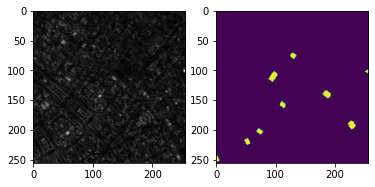

In [ ]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


#Building the Model

In [ ]:
IMG_HEIGHT = X1.shape[1]
IMG_WIDTH  = X1.shape[2]
IMG_CHANNELS = X1.shape[3]

In [ ]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import RMSprop
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'  # also try 'he_normal' but model not converging... 


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
  # model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=RMSprop(lr = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2),'accuracy'])
    model.summary()
    
    return model

In [ ]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 256, 256, 16) 448         input_13[0][0]                   
__________________________________________________________________________________________________
dropout_90 (Dropout)            (None, 256, 256, 16) 0           conv2d_190[0][0]                 
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, 256, 256, 16) 2320        dropout_90[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#Training AKA Fitting 

In [ ]:
%%time
batch_size = 64  
steps_per_epoch = 3*(len(X_train))//batch_size
         
      
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs= 50 , shuffle = True)


Epoch 1/50
27/27 [==============================] - 81s 1s/step - loss: 1.9327 - mean_io_u_10: 0.4773 - accuracy: 0.9268 - val_loss: 0.2933 - val_mean_io_u_10: 0.4783 - val_accuracy: 0.9566
Epoch 2/50
27/27 [==============================] - 27s 1s/step - loss: 0.2505 - mean_io_u_10: 0.4775 - accuracy: 0.9550 - val_loss: 0.2126 - val_mean_io_u_10: 0.4784 - val_accuracy: 0.9568
Epoch 3/50
27/27 [==============================] - 35s 1s/step - loss: 0.2220 - mean_io_u_10: 0.4786 - accuracy: 0.9571 - val_loss: 0.1835 - val_mean_io_u_10: 0.4781 - val_accuracy: 0.9563
Epoch 4/50
27/27 [==============================] - 35s 1s/step - loss: 0.2217 - mean_io_u_10: 0.4762 - accuracy: 0.9524 - val_loss: 0.1783 - val_mean_io_u_10: 0.4775 - val_accuracy: 0.9550
Epoch 5/50
27/27 [==============================] - 27s 1s/step - loss: 0.1878 - mean_io_u_10: 0.4777 - accuracy: 0.9555 - val_loss: 0.1706 - val_mean_io_u_10: 0.4781 - val_accuracy: 0.9563
Epoch 6/50
27/27 [==============================] 

# Graphs to evaluate

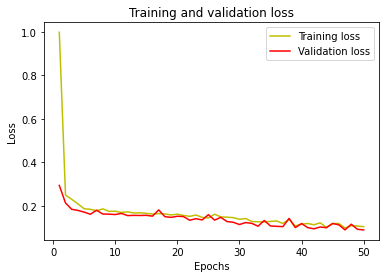

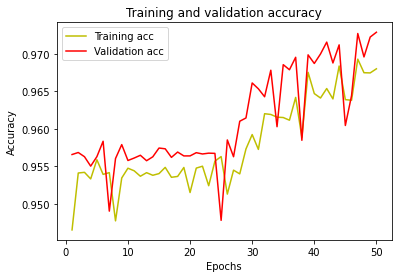

In [ ]:

#plot the training and validation accuracy and loss at each epoch                    
loss = history.history['loss']                
val_loss = history.history['val_loss']           
epochs = range(1, len(loss) + 1)              
plt.plot(epochs, loss, 'y', label='Training loss')        
plt.plot(epochs, val_loss, 'r', label='Validation loss')    
plt.title('Training and validation loss')                    
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()    
 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
%%time 
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5
#print(y_pred)
print(y_pred_thresholded)

[[[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]]


 [[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]]


 [[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[Fal

In [ ]:

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)


IoU score is:  0.49701432685647623


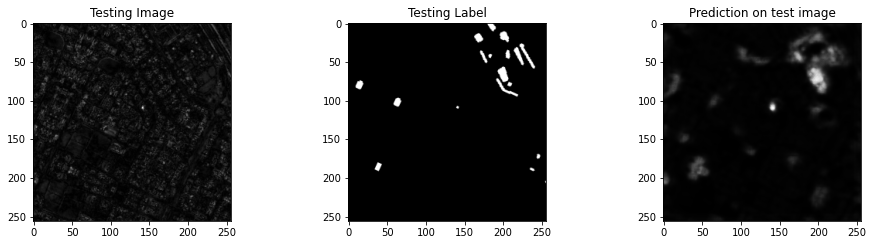

In [ ]:
test_img_number = np.random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
prediction=prediction[0,:,:,0]
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

# plotting some results of the prediction

In [ ]:
r=random.randint(0,len(X_test)-1)
fig=plt.figure()
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
ax=fig.add_subplot(2,2,1)
ax=plt.imshow(np.reshape(y_pred[r]*255,(256,256)),cmap="gray")
ax=fig.add_subplot(2,2,2)
ax.imshow(np.reshape(y_test[r]*255,(256,256)),cmap="gray")

NameError: ignored

#Saving the Model